# Supercell over Brabant - 23-06-2016

This Notebook contains a preliminary analysis of the supercell event over Brabant on the 23rd of June, 2016.

Please read down for the images.

In [1]:
# System modules
import pickle
import folium
from folium import plugins
import pandas as pd
import matplotlib.pyplot as plt

# User modules
from domain.base import Station
import domain.preprocessing as preprocessing
import domain.mongodb_engine as mongodb
from domain.elevation_service import (
    ElevationServiceConnector
)

from helpers.utils import (
    get_station_coordinates,
    add_station_elevations,
    select_near,
    add_alias
)
import helpers.knmi_obs_ingest as knmi
%matplotlib inline

In [2]:
def plot_markers_on_map(station_dict):
    map_1 = folium.Map(
        [51.3, 5.6],
        zoom_start=10, 
    )

    for station_id in station_dict:
        station = station_dict[station_id]
        folium.Marker(
            [station.latitude, station.longitude], 
            popup="Station id alias: N%d" % station.alias,
            icon=folium.Icon(color=station.color)
        ).add_to(map_1)
    return map_1

In [3]:
db_connector = mongodb.MongoDBConnector()

In [4]:
stations = list(db_connector.db.stations.find(
    {},
    {'_id': 0}
))
data_map = {s['station_id']: Station.fromdict(s) for s in stations}

In [6]:
# # In case database is not available, load from file.
# with open('supercell brabant 23-06-2016/data.pkl', 'wb') as f:
#     pickle.dump(data_map, f)

In [ ]:
# In case database is not available, load from file.
# with open('supercell brabant 23-06-2016/data.pkl', 'rb') as f:
#     data_map = pickle.load(f)

In [7]:
stations_with_rain = {}
for station_id in data_map:
    station = data_map[station_id]
    if station.hydro_module is not None:
        stations_with_rain[station_id] = station

## Plotting the area
Below is a map of NetAtmo stations in the South Brabant area that had active rain meters on the 23rd.
The line in the map roughly indicates the trajectory of the storm. Red markers indicate stations included in the analysis. Blue markers are ignored.

In [8]:
# Stations in selected area.
selected_station_ids = [
    'enc:16:ssSepakiAx9wCWboTrTRTG4F/nOv50LXr2+HYMunllSAI0w02A5RV3xh2QocIL0d',
    'enc:16:6EVfiTgh2a0QX6/GKLuhXMXXLZpVT92NOqsRjkg+ZNNbQKewcleIWkBk8BtmK3Gf',
    'enc:16:4VYcIG0byC1368LxapPkhSo7Fr8fE4Flv2Y5tDzqGHMq0n7NoL1BSSj/RUzYlNlq',
    'enc:16:71WudbxCcsjpay9X8+hnInNLDhhBpvfgySaUAMrNGB3CEI84bfcdGlV98rbvfG4r',
    'enc:16:tlJdVNL1ewIDangOS2aXVxe7KZQx9DUs9HCJIgawiL3z3zGcYK9KXISvfx8RBYL7',
    'enc:16:/SuOiA5vJoeIkitImNOo9iPQMxdJvn01XlC9b6cUeduos+r9JaKMWvV7CN6E1ycm',
    'enc:16:+WfJ2lpRvCPynzbLyp8Gg7NdPKlUP1zwFckh8mECn69z/pyuSbsZDXFd6rMShqYz',
    'enc:16:iuvFraExqUTWbfSjYnZr3AG4IBcbPkpc9Lv9CoPZ16Jej5D+/QqXMlEPiJ7O2YDt',
    'enc:16:t7IwxSX6elqfhpc7VWSSsK9DryqcQSiE7QxD/a6k+6LAOhH/qhT9rEnk5SUgM+At'
]

for count, station_id in enumerate(stations_with_rain):
    station = stations_with_rain[station_id]
    station.alias = count
    if station_id in selected_station_ids:
        station.color = 'red'
    else:
        station.color = 'blue'

In [9]:
map_obj = plot_markers_on_map(stations_with_rain)
color_line = folium.PolyLine(
    locations=list([[51.288186, 5.326947], [51.462, 5.79872]]),
    weight=10)
color_line.add_to(map_obj)
map_obj.save('selected_stations.html')
map_obj

## Daily rain sum
For each of the stations - shown in red on the map above - I plot the measured cumulative rainfall. Times are in UTC, amounts in millimeters precipitation measured.
This cumulative rainfall is set back to zero at midnight, local time, explaining the sharp drop at 22:00UTC. 

Each station was given an alias id for human readability, shown in the title of each image. These ids correspond with the number shown when clicking on a marker in the above map.

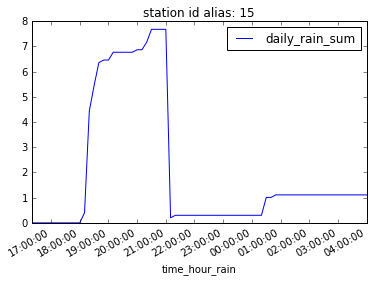

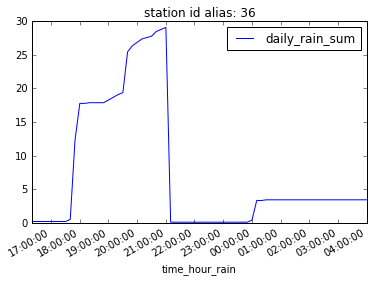

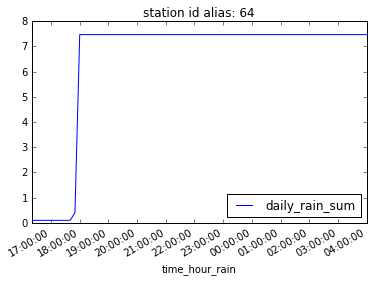

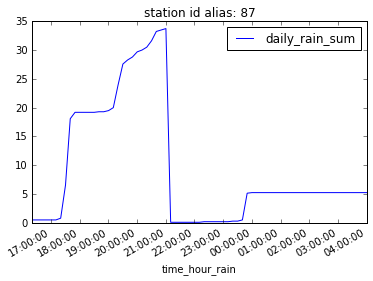

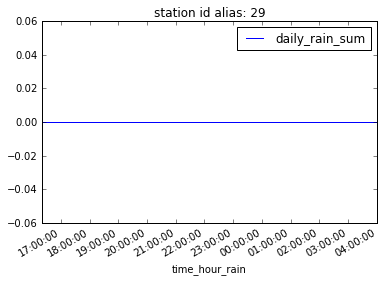

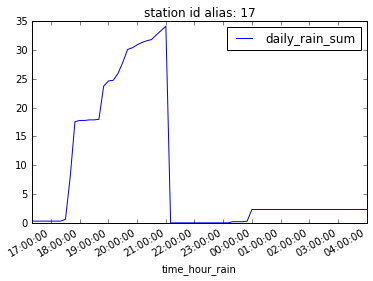

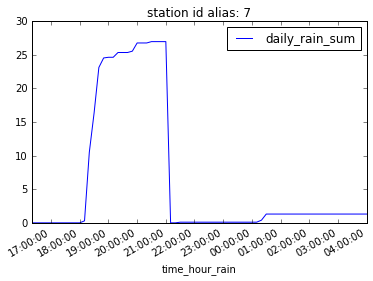

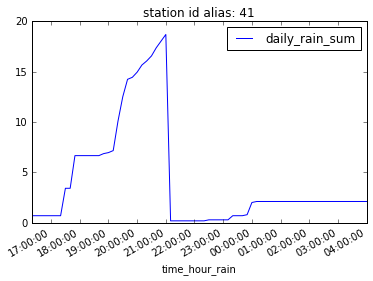

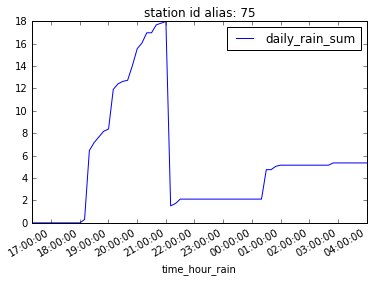

In [15]:
selected_station_map = {s_id: data_map[s_id] for s_id in selected_station_ids}
for station_id in selected_station_map:
    station = selected_station_map[station_id]
    df = pd.DataFrame(station.hydro_module)
    df = df[50:]
    daily_df = df[['time_hour_rain', 'daily_rain_sum']]
    daily_df.set_index('time_hour_rain').plot(title='station id alias: %d' % station.alias)